# <center> Demo </center>

In [8]:
import sklearn.model_selection
from sklearn.datasets import load_digits
import cupy as xp 
import time
from svm import SVM
import kernels

digits = load_digits()

# Divide the data into train, test sets 
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(digits.data, digits.target)

# Move data to GPU
x_train = xp.asarray(x_train)
x_test =  xp.asarray(x_test)
y_train = xp.asarray(y_train)
y_test = xp.asarray(y_test)

x_train_binary, y_train_binary = SVM.filter_data_by_class_ovo(x_train, y_train, [0,1], True)
x_test_binary, y_test_binary = SVM.filter_data_by_class_ovo(x_test, y_test, [0,1], True)

In [9]:
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        
        print('func:%r args:%r took: %2.4f sec' % (f.__name__, kw, te-ts))
        return result

    return timed

@timeit
def train_and_compute_misclassification(classification_strategy, x_train, y_train, x_test, y_test, kernel, kernel_params, lambduh=None, n_folds=3, num_lambda=10, max_iter=100):   
    print('Kernel: {} with parameters {}'.format(kernel, kernel_params))
    svm = SVM(kernel, kernel_params, lambduh, max_iter, classification_strategy, x=x_train, y=y_train, n_folds=n_folds, num_lambda=num_lambda, display_plots=True)

    use_optimal_lambda = False
    if svm._lambduh is None:
        use_optimal_lambda = True

    svm.fit(x_train, y_train, use_optimal_lambda=use_optimal_lambda)
    if svm._classification_strategy == 'binary':
        svm.plot_misclassification_error()

    misclassification_error_train = svm.compute_misclassification_error(x_train, y_train)
    print('Misclassification error (train), {}, optimal lambda = {} : {}\n'.format(svm._classification_strategy, svm._lambduh, misclassification_error_train))

    misclassification_error_test = svm.compute_misclassification_error(x_test, y_test)
    print('Misclassification error (test), {}, optimal lambda = {} : {}\n'.format(svm._classification_strategy, svm._lambduh, misclassification_error_test))


Kernel: linear with parameters {}


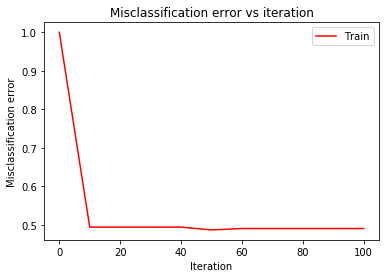

Misclassification error (train), binary, optimal lambda = 1 : 0.0

Misclassification error (test), binary, optimal lambda = 1 : 0.0

func:'train_and_compute_misclassification' args:{'lambduh': 1, 'max_iter': 100} took: 1.5922 sec
Kernel: linear with parameters {}


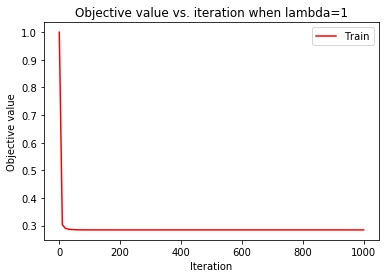

Misclassification error (train), ovr, optimal lambda = 1 : 0.09057164068299926

Misclassification error (test), ovr, optimal lambda = 1 : 0.10222222222222223

func:'train_and_compute_misclassification' args:{'lambduh': 1, 'max_iter': 1000} took: 43.0865 sec
Kernel: rbf with parameters {'sigma': 15}


OutOfMemoryError: out of memory to allocate 928977408 bytes (total 1860272640 bytes)

In [10]:
train_and_compute_misclassification('binary', x_train_binary, y_train_binary, x_test_binary, y_test_binary, 'linear', {}, lambduh=1, max_iter=100)
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'linear', {}, lambduh=1, max_iter=1000)
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'rbf', {'sigma': 15}, lambduh=1, max_iter=100)  


• Train a kernel support vector machine with the huberized hinge loss and the polynomial kernel of order 7 on the the Digits dataset, tuning the regularization parameter λ using cross-validation.

In [ ]:
SVM.train_and_compute_misclassification('binary', x_train, y_train, x_test, y_test, 'poly', {'degree': 7}, max_iter=100, n_folds=3, lambda_max=10**3, num_lambda=10, use_optimal_lambda=True)

In [3]:
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'poly', {'degree': 7}, use_optimal_lambda=True)

NameError: name 'SVM' is not defined

• Compare the performance of kernel SVMs with different kernels (polynomial kernels with different orders, Gaussian RBF with different bandwidths, etc.).

In [22]:
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'linear', {}, .25)
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'poly', {'degree': 3}, .25)
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'poly', {'degree': 15}, .25)
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'rbf', {'sigma': 3}, .25)
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'rbf', {'sigma': 7}, .25)
train_and_compute_misclassification('ovr', x_train, y_train, x_test, y_test, 'rbf', {'sigma': 15}, .25)

Kernel: linear with parameters {}
Misclassification error (test), ovr, optimal lambda = 0.25 : 0.1622222222222222

Kernel: poly with parameters {'power': 3}
Misclassification error (test), ovr, optimal lambda = 0.25 : 0.5222222222222223

Kernel: poly with parameters {'power': 15}
Misclassification error (test), ovr, optimal lambda = 0.25 : 0.6311111111111111

Kernel: rbf with parameters {'sigma': 3}
Misclassification error (test), ovr, optimal lambda = 0.25 : 0.35777777777777775

Kernel: rbf with parameters {'sigma': 7}
Misclassification error (test), ovr, optimal lambda = 0.25 : 0.27555555555555555

Kernel: rbf with parameters {'sigma': 15}
Misclassification error (test), ovr, optimal lambda = 0.25 : 0.057777777777777775

